<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/VMDEncoderWindSpeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vmdpy


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from vmdpy import VMD

def apply_vmd(series, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-7):
    """
    Applies VMD to a 1D series.

    Returns:
        u: IMFs array of shape (K, length of series)
        omega: center frequencies
    """
    series = series.flatten()
    u, u_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)
    return u, omega


In [ ]:
df  = pd.read_csv("data.csv",parse_dates = True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date')
wind_series = df["ws"].values

In [ ]:
u, omega = apply_vmd(wind_series)

In [ ]:
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print(df.info())
print(f"DESCRIPTION: {df.describe()}")
print(f"Start date: {pd.to_datetime(df['date'].min())}")
print(f"End date: {pd.to_datetime(df['date'].max())}")
#print(f"Frequency (approx): {pd.infer_freq(df.index)}")


Number of samples: 44688
Number of features: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44688 entries, 0 to 44687
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         44688 non-null  datetime64[ns]
 1   tempr        44688 non-null  float64       
 2   ap           44688 non-null  float64       
 3   ws           44688 non-null  float64       
 4   rh           44688 non-null  float64       
 5   blizzard     44688 non-null  int64         
 6   ws_filtered  44688 non-null  float64       
 7   ap_filtered  44688 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 2.7 MB
None
DESCRIPTION:                       date         tempr            ap            ws  \
count                44688  44688.000000  44688.000000  44688.000000   
mean   2018-07-19 23:30:00     -9.622356    980.463455     13.092534   
min    2016-01-01 00:00:00    -39.350000    950.0100

In [ ]:
modes = u.T #Shape: (length,K)


train_size = int(0.8*len(modes))
val_size = int(0.1*len(modes))
print(f"Training data starts at: {pd.to_datetime(df['date'].min())}")
print(f"Training data ends at : {df['date'][train_size-1]}")
print(f"Training size is : {int((train_size)/24)} days")
print("---------------------------------------------------------------")
print(f"Validation data starts at: {df['date'][train_size ]}")
print(f"Validation data ends at: {df['date'][train_size + val_size -1]}")
print(f"Validation data size is : {int((val_size)/24)}")
print("---------------------------------------------------------------")
print(f"Testing data starts at: {df['date'][train_size+val_size]}")
print(f"Testing data ends at: {pd.to_datetime(df['date'].max())}")
print(f"Testing data size is : {int((len(modes)-train_size-val_size)/24)}")

train_data = modes[:train_size]
val_data = modes[train_size:train_size+val_size]
test_data = modes[train_size+val_size:]




Training data starts at: 2016-01-01 00:00:00
Training data ends at : 2020-01-29 13:00:00
Training size is : 1489 days
---------------------------------------------------------------
Validation data starts at: 2020-01-29 14:00:00
Validation data ends at: 2020-08-02 17:00:00
Validation data size is : 186
---------------------------------------------------------------
Testing data starts at: 2020-08-02 18:00:00
Testing data ends at: 2021-02-04 23:00:00
Testing data size is : 186


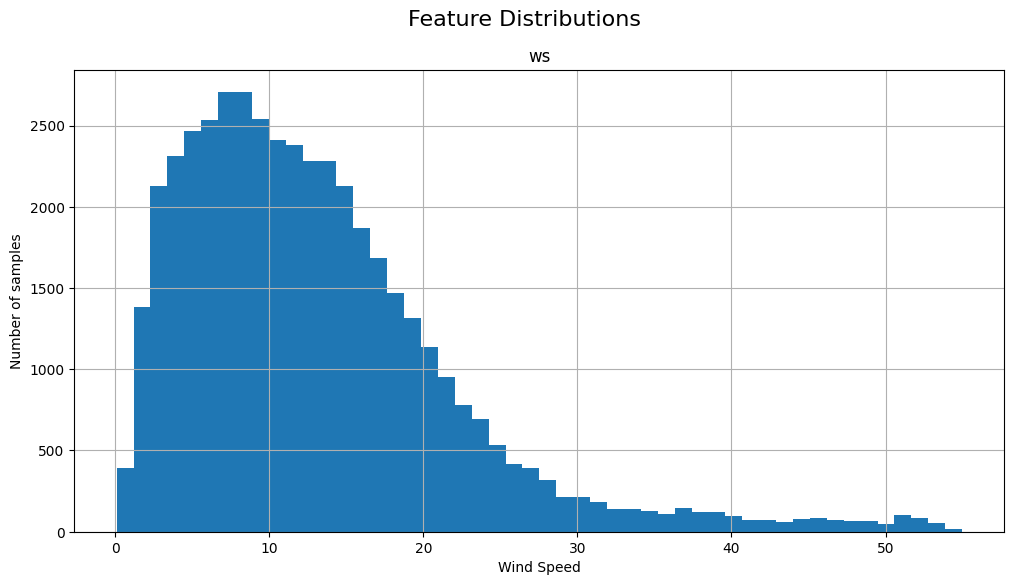

In [ ]:
important_columns = ['ws']  # Example columns

df[important_columns].hist(bins=50, figsize=(12, 6))
plt.suptitle("Feature Distributions", fontsize=16)
plt.xlabel("Wind Speed")
plt.ylabel("Number of samples")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

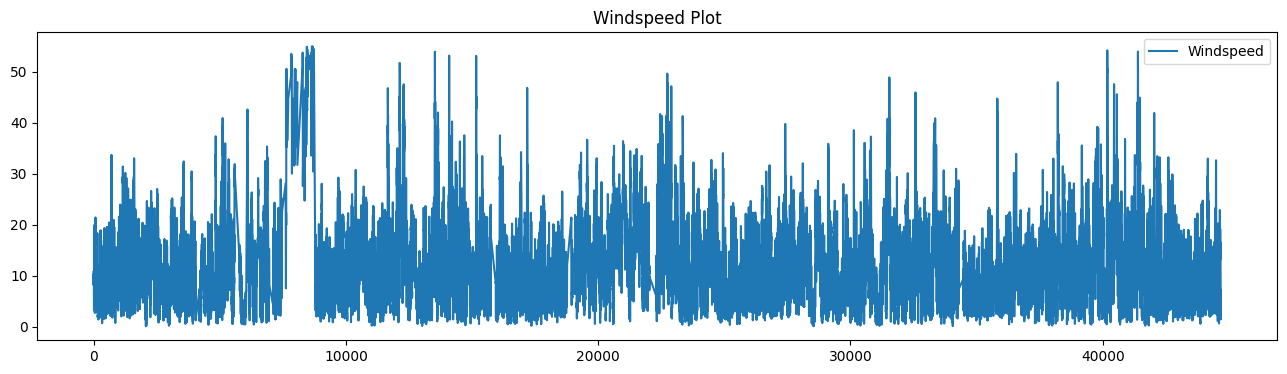

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df["ws"],label = "Windspeed")

plt.title("Windspeed Plot")
plt.legend()
plt.show

In [ ]:
class VMDWeatherDataset(Dataset):
    def __init__(self, data, input_len=36, output_len=12):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len
        self.total_len = input_len + output_len

    def __len__(self):
        return len(self.data) - self.total_len

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.input_len]
        target_seq = self.data[idx+self.input_len:idx+self.total_len]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)


In [ ]:
batch_size = 32

train_dataset = VMDWeatherDataset(train_data)
val_dataset = VMDWeatherDataset(val_data)
test_dataset = VMDWeatherDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)



In [ ]:
input_dim = u.shape[0]
output_dim = u.shape[0]

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell


class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        # Repeat decoder hidden for all src_len steps
        repeated_hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((encoder_outputs, repeated_hidden), dim=2)))
        attention = self.v(energy).squeeze(2)  # shape: (batch_size, src_len)
        weights = torch.softmax(attention, dim=1)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hidden_dim)
        return context



class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.attention = BahdanauAttention(hidden_dim, hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        context = self.attention(hidden, encoder_outputs)  # (batch_size, 1, hidden_dim)
        lstm_input = torch.cat((input, context), dim=2)    # (batch_size, 1, output_dim + hidden_dim)

        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(outputs)
        return prediction, hidden, cell



In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, target_len, target_seq=None, teacher_forcing_ratio=0.5):
        batch_size, _, input_dim = src.shape
        outputs = []

        encoder_outputs, hidden, cell = self.encoder(src)
        input_decoder = src[:, -1:, :]  # last time step input

        for t in range(target_len):
            output, hidden, cell = self.decoder(input_decoder, hidden, cell, encoder_outputs)
            outputs.append(output)

            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_decoder = target_seq[:, t:t+1, :]
            else:
                input_decoder = output

        return torch.cat(outputs, dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model instantiation
encoder = Encoder(input_dim=input_dim, hidden_dim=64, num_layers=2)
decoder = Decoder(output_dim=output_dim, hidden_dim=64, num_layers=2)
model = Seq2Seq(encoder=encoder, decoder=decoder, device=device).to(device)

# Training hyperparameters
num_epochs = 25
teacher_forcing_ratio = 0.5
clip_grad_norm = 1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

best_val_loss = float('inf')

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (src, target) in enumerate(train_loader):
        src = src.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(
            src,
            target_len=target.size(1),
            target_seq=target,
            teacher_forcing_ratio=teacher_forcing_ratio
        )  # output: [batch_size, target_len, K]

        loss = criterion(output, target)
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src_val, target_val in val_loader:
            src_val = src_val.to(device)
            target_val = target_val.to(device)

            output_val = model(src_val, target_len=target_val.size(1), target_seq=None, teacher_forcing_ratio=0.0)
            val_loss += criterion(output_val, target_val).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_seq2seq_attention_vmd.pt')
        print("✅ Saved new best model!")

✅ RMSE: 0.8612
✅ R² Score: 0.9895


/tmp/ipython-input-19-3024476656.py:54: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-19-3024476656.py:55: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.savefig("wind_seq2seq_vmd_attention.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


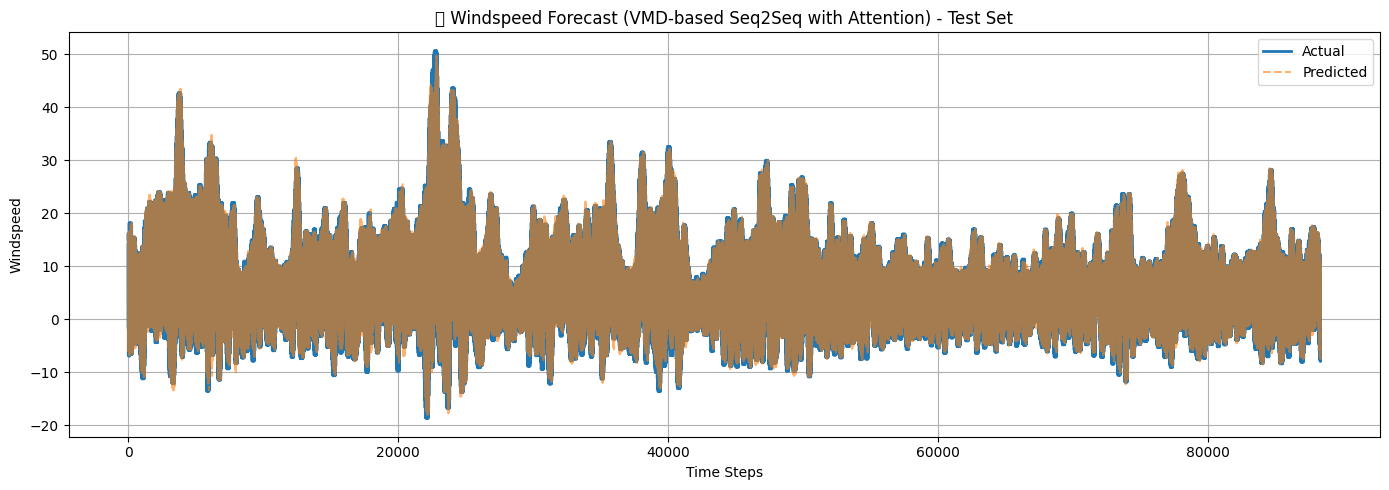

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# 📦 Load best model
model.load_state_dict(torch.load('best_seq2seq_attention_vmd.pt', map_location=torch.device('cpu')))
device = torch.device('cpu')
model.to(device)
model.eval()

# 🔍 Run model over entire test set
all_preds = []
all_trues = []

with torch.no_grad():
    for src_batch, target_batch in test_loader:
        src_batch = src_batch.to(device)
        target_batch = target_batch.to(device)

        output_batch = model(
            src_batch,
            target_len=target_batch.size(1),
            target_seq=None,
            teacher_forcing_ratio=0.0
        )

        all_preds.append(output_batch.cpu())
        all_trues.append(target_batch.cpu())

# 🧱 Stack and reshape to (N, K) where K = number of modes
pred_full = torch.cat(all_preds, dim=0).reshape(-1, 3).numpy()
true_full = torch.cat(all_trues, dim=0).reshape(-1, 3).numpy()

# ➕ Reconstruct final windspeed series by summing modes
pred_total = np.sum(pred_full, axis=1)
true_total = np.sum(true_full, axis=1)

# 📉 Evaluation metrics
rmse = mean_squared_error(true_total, pred_total) ** 0.5
r2 = r2_score(true_total, pred_total)
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 📊 Plot
plt.figure(figsize=(14, 5))
plt.plot(true_total, label='Actual', linewidth=2)
plt.plot(pred_total, label='Predicted', linestyle='--',alpha = 0.6)
plt.title("🌬️ Windspeed Forecast (VMD-based Seq2Seq with Attention) - Test Set")
plt.xlabel("Time Steps")
plt.ylabel("Windspeed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wind_seq2seq_vmd_attention.png", dpi=600)
plt.show()


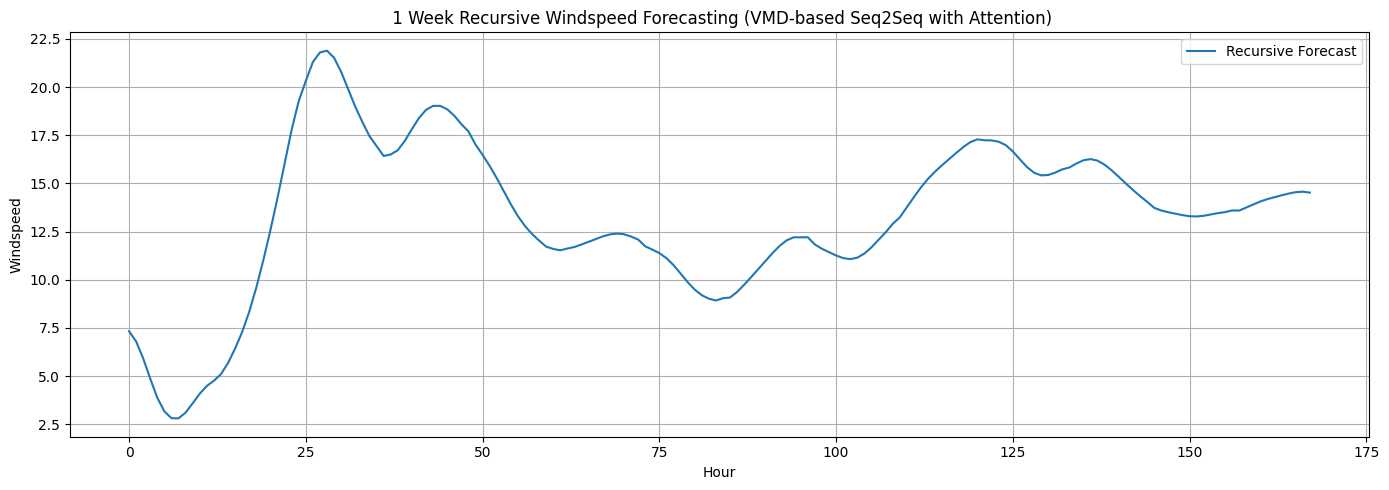

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

input_len = 36
output_len = 12
forecast_horizon = 168  # 7 days × 24 hours

# Assume: modes_test (numpy array of shape [N, K]), model, input_len, output_len already defined
K = test_data.shape[1]  # Number of VMD modes

device = torch.device('cpu')
model.load_state_dict(torch.load("best_seq2seq_attention_vmd.pt", map_location=device))
model.to(device)
model.eval()

# Get last input window
initial_input = torch.tensor(
    test_data[-input_len:], dtype=torch.float32
).unsqueeze(0).to(device)  # Shape: [1, input_len, K]

predictions_modes = []

with torch.no_grad():
    current_input = initial_input.clone()

    for _ in range(0, forecast_horizon, output_len):
        output = model(current_input, target_len=output_len, target_seq=None, teacher_forcing_ratio=0.0)
        output = output.squeeze(0).cpu().numpy()  # [output_len, K]

        predictions_modes.append(output)

        prev_input_np = current_input.squeeze(0).cpu().numpy()
        updated_input = np.concatenate([prev_input_np, output], axis=0)[-input_len:]
        current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

# Stack all predictions
pred_modes = np.concatenate(predictions_modes, axis=0)[:forecast_horizon]  # [forecast_horizon, K]

# Reconstruct final windspeed by summing modes
final_forecast = np.sum(pred_modes, axis=1)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label="Recursive Forecast", color='tab:blue')
plt.title(" 1 Week Recursive Windspeed Forecasting (VMD-based Seq2Seq with Attention)")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("recursive_forecast_vmd_attention.png", dpi=600)
plt.show()


In [ ]:
forecast_horizon = 336  # 7 days × 24 hours

# Assume: modes_test (numpy array of shape [N, K]), model, input_len, output_len already defined
K = test_data.shape[1]  # Number of VMD modes

device = torch.device('cpu')
model.load_state_dict(torch.load("best_seq2seq_attention_vmd.pt", map_location=device))
model.to(device)
model.eval()

# Get last input window
initial_input = torch.tensor(
    test_data[-input_len:], dtype=torch.float32
).unsqueeze(0).to(device)  # Shape: [1, input_len, K]

predictions_modes = []

with torch.no_grad():
    current_input = initial_input.clone()

    for _ in range(0, forecast_horizon, output_len):
        output = model(current_input, target_len=output_len, target_seq=None, teacher_forcing_ratio=0.0)
        output = output.squeeze(0).cpu().numpy()  # [output_len, K]

        predictions_modes.append(output)

        prev_input_np = current_input.squeeze(0).cpu().numpy()
        updated_input = np.concatenate([prev_input_np, output], axis=0)[-input_len:]
        current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

# Stack all predictions
pred_modes = np.concatenate(predictions_modes, axis=0)[:forecast_horizon]  # [forecast_horizon, K]

# Reconstruct final windspeed by summing modes
final_forecast = np.sum(pred_modes, axis=1)

# Plot
plt.figure(figsize=(14, 5))
plt.plot(final_forecast, label="2- Week Recursive Forecast", color='tab:blue')
plt.title("Recursive Windspeed Forecasting (VMD-based Seq2Seq with Attention)")
plt.xlabel("Hour")
plt.ylabel("Windspeed")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("2 week recursive_forecast_vmd_attention.png", dpi=600)
plt.show()